# Flood monitoring using Sentinel2 and STAC

This blog/exercise presents a full workflow from download to analysis for Sentinel 2 data for a real life application: flood monitoring.

The workflow is divided in 8 sections:

1. Definining AOI
2. STAC API search and query
3. Download and processing of data for one date
4. Processing pipeline: mulitple dates
5. Visualization of flooding in time series
6. Quality and pixel masking
7. Analysis of time series profile and flood impact
8. Conclusions.
9. References

Given the processing pipeline length and complexity, this exercise is also split into three parts with more in-depth explanations in separate blogs/exercises showing the processes of:

- Sentinel 2 STAC query and download-process
- Quality and pixel masking of Sentinel 2
- Time series anlysis for flooding

# Data

We use data products from the Sentinel 2 Mission from the Copernicus programme. Sentinel 2 consists of two satellite platforms collecting imagery with the same multi spectral Imagery sensor. There are two satellites:

- Sentinel 2A was launched on June 23
- Sentinel 2B was launched on March 7 2017.

Sentinel 2 satellites have revisit time of 10 days under the same angles with higher revisit times in higher latitudes and more revisit times if we consider both Sentinel 2A and 2B together. Sentinel 2 data is distributed as granules (tiles) that are 100x100 km2 ortho-images in UTM/WGS84 projection.

Because the satellite path crosses the meridians the tiles collected are triangular or trapezoidal in shape and do not follow the UTM square gridding used to distribute the data.

# Abrupt Event

To explore the use of Sentinel 2 data, we use Vermont flooding that occured between July 9 and 11, 2023. This flood event had a major impact on the state with 14 counties declared as state disaster. River levels increased across the state and the Winooski River near Montpellier, the state capital, jumped by 14 feet within a 20 hour time period.


# Using STAC to explore and download COGS data

STAC or Spatial Temporal Assets Catalog along with COG (Cloud Optimized Geotiff) are quickly becoming a standard in distributing Earth Observation data. In this blog/exercise, we provide an example of a STAC catalog exploration and search with the aim of downloading and processing Sentinel 2 COGS data using open source tools (GDAL, rasterio and xarray).

## Interesting links:

- GDAL tutorial:

https://www.kaggle.com/code/samanemami/a-complete-tutorial-on-raster-data-analysis?scriptVersionId=110771922

- STAC and COGS

Each pystac.Item <https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item>__ in this ItemCollection includes all the metadata for that scene. STAC Items are GeoJSON features, and so can be loaded by libraries like geopandas.

- course:

http://spatial-ecology.net/docs/build/html/WEBSEMINAR/webseminar.html

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/pystac-client-introduction.ipynb

https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html


- Analyzing sentinel 2 with GEE in python:

https://worldbank.github.io/OpenNightLights/tutorials/mod6_3_intro_to_sentinel2.html


- GDAL Time series

https://ucl-eo.github.io/geog0111/041_GDAL_timeseries_answers/


https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html

https://gis.stackexchange.com/questions/178535/how-can-i-use-gdal-merge-with-multiple-files-in-one-folder-in-python-2-7


- Copernicus Dataspace Ecosystem

https://documentation.dataspace.copernicus.eu/APIs/STAC.html


- Visualize and explore multibands time series from Sentinel with xarray


https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391

- NASA Earth data via STAC

https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html

https://hls.gsfc.nasa.gov/products-description/tiling-system/

- Flooding datasets:

https://github.com/cloudtostreet/Sen1Floods11

- Flooding event in Vermont:

https://floodlist.com/america/usa/floods-vermont-july-2023

https://www.vermontpublic.org/2023-07-13/maps-which-areas-in-vermont-were-hit-hardest-in-this-weeks-flooding

https://maps.disasters.nasa.gov/arcgis/apps/MinimalGallery/index.html?appid=79638a63d4824520bb3360415b37a9bd

https://maps.disasters.nasa.gov/download/gis_products/event_specific/2023/vermont_flooding_202307/sentinel2/20230706/cir/

https://cimss.ssec.wisc.edu/satellite-blog/archives/53377


- visualizes the boundaries of the S-2 granules imaged on a single day.

https://gis.stackexchange.com/questions/395456/why-is-the-sentinel-2-image-plot-triangular-in-google-earth-engine


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

First let's list a few parameters to understand the computing environment that we are using. In particular:
- os system
- python version
- hostname

In [1]:
!uname -a
!lsb_release -a
!python --version
!hostname
!whoami

Linux 0bfb2e018fb7 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Python 3.10.12
0bfb2e018fb7
root


Let's then install GDAL binaries and spatial libraries necessary for gdal, rasterio and xarray.

In [2]:
#install gdal to run from the terminal
!sudo add-apt-repository ppa:ubuntugis/ppa -y
!sudo apt-get update
!sudo apt-get install gdal-bin
!gdalinfo --version

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRele

Install other geospatial related libraries

In [88]:
#set up libararies for GIS/Geospatial
!pip install fiona

try: # try the following b+lock of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd

try:
  import contextily as ctx # import
  import rasterio
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install rasterio
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon

!pip install pyproj
# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

from collections import OrderedDict
#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#xarray and rio
!pip install rioxarray
!pip install mapclassify
!pip install earthpy
import shapely

import mapclassify
import folium
import pyproj as proj
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
from folium.utilities import none_max
import folium
from pyproj import Transformer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


General purpose libraries and packages

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

from pathlib import Path

sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
!apt install unzip
import urllib
import re
import math
from datetime import datetime
from copy import deepcopy
from numpy.core.multiarray import datetime_as_string
import os
import numpy.ma as ma

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [5]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

Install STAC related libraries

- https://pystac-client.readthedocs.io/_/downloads/en/stable/pdf/
- https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/aoi-coverage.ipynb


In [6]:
!pip install pystac
#!pystac_client
!pip install pystac-client
!pip install planetary-computer
import planetary_computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00


In [7]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [8]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

In [9]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path



In [10]:
def dms_to_dd(val: np.float32) -> np.float32:
  '''
  Convert dms: degree minute second to decimal degree
  Note that the format expect direction with W or S.

  :param val: degree minute second
  :return: decimal degree
  '''

  deg,minute,second,direction = re.split('[°\'\"]', val)
  dd_val = float(deg)+float(minute)/60+float(second)/(60*60)
  if direction == 'W' or direction == 'S':
    dd_val = (-1.)*dd_val
  return dd_val

In [11]:

def bbox_to_poly(bbox: list) -> Polygon:

  '''
  Convert bounding box list into a polygon. With input list xmin,ymin,xmax,ymax.

  :param bbox list: list of coordinates represending a bouding.
  :return: Shapely polygon

  '''

  long0 = bbox[0]
  lat0 = bbox[1]
  long1=bbox[2]
  lat1=bbox[3]

  poly = Polygon([[long0, lat0],
                        [long1,lat0],
                        [long1,lat1],
                        [long0, lat1]])

  return poly

In [12]:
def polygon_from_centroid(x_centroid,y_centroid,size,EPSG_val=4326)-> gpd.GeoDataFrame:

  '''

  Generate a square polygon from center point with a given size and EPSG code
  Return a GeoDataFrame

  :param x_centroid float32: x center of square polygon being created
  :param y_centroid float32: y center of square polygon being created
  :param size float32: length of square polygon
  :param EPSG_val int: EPSG code defining the coordinate system
  :return geopandas geodataframe

  '''

  xmin = x_centroid - size/2
  xmax = x_centroid + size/2
  ymin = y_centroid - size/2
  ymax = y_centroid + size/2

  bbox_list = [xmin,ymin,xmax,ymax]
  bbox_poly = bbox_to_poly(bbox_list)

  bbox_poly_gdf = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
         crs = {'init':f'epsg:{EPSG_val}'},
         geometry = [bbox_poly])
  bbox_poly_gdf.to_file('bbox_poly.shp')

  return bbox_poly_gdf

In [13]:
#https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def items_to_geodataframe(items: any) -> gpd.GeoDataFrame:
    '''
    Convert a list of STAC Items into a GeoDataFrame.
    Modified from https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb

    :param items: list of STAC Items
    :return: GeoDataFrame
    '''

    #Using from copy import deepcopy
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

In [14]:
from pystac_client import item_search
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def get_selected_products_and_bands(cat_search: item_search.ItemSearch,
                                    bands_selected: list[str],
                                    platform: str='Sentinel-2A') -> pd.DataFrame:

  '''
  Get the selected products and bands from STAC

  :param items: pystac_client item search object
  :param bands_selected: list of bands to filter
  :return: pandas data frame containing the selected products and bands
  '''

  items_dict = [i.to_dict() for i in cat_search.get_items()]
  print(f"{len(items_dict)} scenes fetched")
  items = items_to_geodataframe(items_dict)
  bands_selected = [f'assets.{b}.href'for b in bands_selected]
  bands_selected
  col_selected = bands_selected + ['collection','id','properties.s2:mgrs_tile','properties.proj:epsg']
  if platform is not None:
    selected_products = items.loc[items['properties.platform']==platform,col_selected] #filter for relevant platform
  else:
    selected_products = items.loc[:,col_selected] #filter for relevant platform

  selected_products = selected_products.reset_index()
  print(selected_products['properties.datetime'].dtypes)
  selected_products['date'] = selected_products['properties.datetime'].dt.date
  selected_products['date'] = selected_products['date'].astype(str)
  list_dates = list(selected_products['date'].unique())
  list_tiles = selected_products['properties.s2:mgrs_tile'].unique()

  return selected_products

In [15]:
#Change the name of the file to include date and better formatting
#Also adjust the resolution
def download_and_reproject_stac_file(date_val:str,
                                     selected_products:pd.DataFrame,
                                     download: bool,
                                     aoi_poly:gpd.GeoDataFrame,
                                     output_epsg: int=None,
                                     output_res: np.float32=None,
                                     out_dir:str='.') -> str:
  '''
  Download and reproject STAC files

  :param date_val: str: date to download and process
  :param selected_products: pd.DataFrame
  :param download: boolean, if true download the raw file without processing
  :param aoi_poly: gpd.GeoDataFrame containing the reference poygon of Area of Interest
  :param output_epsg: int code for EPSG projection coordinate system
  :param output_res: np.float32 resolution of output raster
  :param out_dir: str path to output directory
  :return: output raster file name containing the processed raster
   '''

  bands_cols = list(selected_products.filter(regex='assets').columns)

  for band in bands_cols:
    if download is True:
        raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()
        out_raster_file =[]
        for raster_file in raster_file_list:
           download_path = os.path.join(selected_products.collection)
           in_filename = raster_file
           out_filename = os.path.basename(in_filename.split('?'))[0] #split the name on ?
           os.makedirs(download_path, exist_ok=True)
           out_filename = os.path.join(out_dir,out_filename)
           urllib.request.urlretrieve(in_filename,
                                   out_filename)

           out_raster_file.append(out_filename)

    #crop and project if download is false
    if download is False:

      # Set the AOI cropping
      proj_crs = selected_products.loc[selected_products['date']==date_val,'properties.proj:epsg'].tolist()
      print(proj_crs) #this is the EPSG code
      aoi_poly_proj = aoi_poly.to_crs(f'EPSG:{proj_crs[0]}') #should first extract current EPSG!!
      aoi_poly_proj.to_file('aoi_poly_proj.shp')
      aoi_poly_proj.crs

      #Set the resolution for the ouput
      if output_res is None:
        #if unit is degree we need to call a function
        #if not we use the same res as input
        output_res=0.00009
        #this still needs to be improve
        #use input raster to match the res in the output projection given
      if output_epsg is None:
        crs_val=(aoi_poly.crs.srs)
        epsg_code = crs_val.split(':')[1][:4]
        output_epsg = f'EPSG:{epsg_code}'
      data_val_formatted = date_val.replace("-","")

      download_path = os.path.join(selected_products.collection.unique()[0],
                                    data_val_formatted)
      os.makedirs(download_path, exist_ok=True) # add date

      out_filename=os.path.join(out_dir,
                                download_path, #add date in output path?
                                f'crop_proj_{selected_products2.collection.unique()[0]}_{band}_{data_val_formatted}.tif')
      raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()

      #from pathlib import Path
      out_filename_vrt = Path(out_filename).stem

      raster_file_list_m = [f'/vsicurl/{u}' for u in raster_file_list]

      ds = gdal.BuildVRT( f'{out_filename_vrt}.vrt',
                         raster_file_list_m,
                          VRTNodata=0,
                          srcNodata=0)

      #dstSRS should not be hard coded
      result = gdal.Warp(out_filename,
                          ds,
                          format='GTiff',
                          dstNodata=0,
                          dstSRS= output_epsg, #this should not be hard coded
                          cutlineDSName='aoi_poly_proj.shp',
                          cropToCutline=True,
                          xRes=output_res, #this should not be hard coded
                          yRes=output_res)
      result=None
      out_raster_file = out_filename

  return out_raster_file

In [16]:
#https://gis.stackexchange.com/questions/290796/how-to-edit-the-metadata-for-individual-bands-of-a-multiband-raster-preferably
def update_description_gdal(filepath: str,
                            list_desc: List) -> str:

  '''
  Update the description of a raster file using GDAL

  :param filepath: path/virtual path/uri to raster
  :param list_desc: list of string values for each band description, eg dates
  :return: str stating that the description was updated
  '''

  ds_src = gdal.Open(filepath, gdal.GA_Update)
  i=0
  for desc_val in list_desc:
    i=i+1
    rb = ds_src.GetRasterBand(i)
    rb.SetDescription(desc_val)
  del ds_src
  return "updated descriptions"

In [17]:
## Now set no data and description + recalculate stats after that

def update_nodata_val_raster(in_filename: str,
                             band_val: int=1,
                             nodata_val: int=0) -> str:
  '''
  Update the nodata value of a raster file using GDAL

  :param in_filename: path to raster filep
  :param band_val: band number
  :param nodata_val: nodata value to set
  :return: str stating that the description was updated

  '''

  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  rb.SetNoDataValue(nodata_val)
  rb= None
  ds = None
  return 'Nodata value updated'

In [18]:
def generate_qa_table_sentinel2() -> pd.DataFrame:

  '''

  Generate a reference table wtih value and corresponding label description for Sentinel 2
  Quality Pixel from teh Scene Land Classificaiton

  :return DataFrame with SCL description
  '''

  #https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html
  #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

  from io import StringIO, BytesIO

  text_string = StringIO("""value,class,HTLM color code
  0,No Data (Missing data),#000000
  1,Saturated or defective pixel,#ff0000
  2,Dark features/Shadows',#2f2f2f
  3,Cloud shadows,#643200
  4,Vegetation,#00a000
  5,Not-vegetated,#ffe65a
  6,Water,#0000ff
  7,Unclassified,#808080
  8,Cloud medium probability,#c0c0c0
  9,Cloud high probability,#ffffff
  10,Thin cirrus,#64c8ff
  11,Snow or ice,#ff96ff
  """)
  SCL_legend_df = pd.read_csv(text_string, sep=",")

  return  SCL_legend_df

In [19]:
def generate_apply_qa_raster_sentinel2(mask_values: List[int],
                                       input_filename_qa: str,
                                       input_filename_var: str,
                                       output_filename: str,
                                       in_dir: str,
                                       max_val: int = 10000,
                                       out_dir: str ='.'
                                       ) -> tuple[str,str]:

  '''
  Apply masking of qa pixel values on Sentinel 2 product.
  Users profiles a list of values to mask.

  :param mask_values: list of values to mask
  :param input_filename_qa: input filename containing SCL QA pixel values
  :param input_filename_var: Sentinel 2 band product filename e.g. B03 reflectance band
  :param in_dir: input directory containing files
  :param out_dir: output directory for files
  :return tuple cmd_str, output_filename

  '''
  df_legend_SCL =generate_qa_table_sentinel2()
  df_legend_SCL['valid']=df_legend_SCL.apply(lambda x: 0 if x.value in mask_values else 1,axis=1)#df2 = df.apply(lambda x: np.square(x) if x.name in ['A','B'] else x)
  df_legend_SCL['valid']
  list_pix_val = df_legend_SCL['value'].tolist()
  list_valid = df_legend_SCL['valid'].tolist()

  if max_val is None:
    max_val = 65536 #this will take all the value below the max for uint16

  os.chdir(in_dir)


  list_args =['gdal_calc.py',
              f'-A {input_filename_qa}',
              f'-B {input_filename_var}',
              '--A_band=1',
              '--B_band=1',
              f'--calc="(A=={list_pix_val[0]})*{list_valid[0]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[1]})*{list_valid[1]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[2]})*{list_valid[2]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[3]})*{list_valid[3]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[4]})*{list_valid[4]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[5]})*{list_valid[5]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[6]})*{list_valid[6]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[7]})*{list_valid[7]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[8]})*{list_valid[8]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[9]})*{list_valid[9]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[10]})*{list_valid[10]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[11]})*{list_valid[11]}*(B<={max_val})*B"',
              '--hideNoData',
              '--overwrite',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])
  #print(cmd_str)
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  #print(output_sub)
  #os.chdir(out_dir)

  return cmd_str, output_filename


In [20]:
def freq_array(r: str|rasterio.io.DatasetReader,
               band_number: int=1) -> pd.DataFrame:

  '''
  Compute unique values and frequency for raster input.

  :param r: input raster filename or rasterio dataset
  :param band_number: band number for rasterio dataset
  '''
  if isinstance(r,rasterio.io.DatasetReader):
    r = r.read(band_number)
  unique, counts = np.unique(r, return_counts=True)
  unique_val = np.asarray((unique, counts)).T
  unique_val_df = pd.DataFrame(unique_val,columns=['value','count'])
  return unique_val_df

In [21]:
def extract_proj_unit(epsg_val: int =4326) -> pd.DataFrame:

  '''
  Extract unit used in Coordinate Reference System identified by the EPSG code
  provided.

  :param  epsg_val: EPSG code value for coordinate reference system
  :return data frame containing unit, direction, name of CRS
  '''

  pyproj_crs = proj.CRS.from_epsg(epsg_val)
  list_unit_crs = [ai.unit_name for ai in pyproj_crs.axis_info]
  list_name_crs = [ai.name for ai in pyproj_crs.axis_info]
  list_direction_crs = [ai.direction for ai in pyproj_crs.axis_info]
  list_abbrev_crs = [ai.abbrev for ai in pyproj_crs.axis_info]
  proj_unit_df = pd.DataFrame.from_dict({"unit":list_unit_crs,
                        "name": list_name_crs,
                        "abbrev": list_abbrev_crs,
                        "direction": list_direction_crs})
  #https://gis.stackexchange.com/questions/299759/where-to-lookup-the-units-associated-with-epsg-code

  return proj_unit_df

In [22]:
def match_spatial_resolution(aoi_poly: gpd.GeoDataFrame,
                             in_file_raster: str,
                             epsg_raster: int =None,
                             epsg_poly: int=None) -> float:
  '''
  Match spatial resolution of the input raster given a geopandas data frame for the AOI polygon.

  :param aoi_poly geodataframe corresponding to the area of interest.
  :param in_file_raster: name of input raster file
  :param epsg_raster: EPSG code for raster, if None read for input raster
  :param epsg_poly: EPSG code for AOI polygon, if None read from input AOI geodataframe

  '''

  print(raster_file_list[0])
  ds_r = rasterio.open(in_file_raster)
  res_x= ds_r.transform.a
  res_y= ds_r.transform.e
  if epsg_raster is None:
    epsg_val_r = ds_r.crs.to_epsg()

  if epsg_poly is None:
    crs_val=(aoi_poly.crs.srs)
    epsg_val_poly = crs_val.split(':')[1][:4]

  r_unit_df = extract_proj_unit(epsg_val_r)
  poly_unit_df = extract_proj_unit(epsg_val_poly)

  unit_r = np.unique(r_unit_df.unit.values)[0]
  unit_poly = np.unique(poly_unit_df.unit.values)[0]

  if (unit_poly=='degree') and (unit_r=='metre'):
    ratio_km = 1000/res_x
    output_res = round((1/111)/ratio_km, 5)
  if (unit_poly=='degree') and (unit_r=='degree'):
    output_res = res_x
  if (unit_poly=='metre') and (unit_r=='metre'):
    output_res=res_x
  return output_res

In [23]:
def plot_raster_categories(in_filename: str,
                           color_list: List =None,
                           class_names: List[str]=None,
                           title_str: str=None)->str:
  '''
  Plot categorical raster given input file name

  :param in_filename: input file name
  :param color_list: list of colors for categories plotted
  :param class_names: list of categories names
  :title_str: title for the plot
  :return title_str: 'plotted' message
  '''

  if title_str is None:
    title_str =""
  sns.set(font_scale=1.5, style="whitegrid")

  ## Loading TIF file
  r_rxr = rxr.open_rasterio(in_filename,
                            masked=True).squeeze()
  r_rxr = r_rxr.astype('uint16')

  ### Getting unique classes from array and setting color and legend list

  classes_rxr = list(np.unique(r_rxr).astype('int'))
  n_classes = len(classes_rxr)
  # Plot newly classified and masked raster
  if color_list is None:
    color_list = sns.color_palette("pastel",n_classes)
    color_list =list(color_list.as_hex())
  if class_names is None:
    class_names = ['class_' + str(i) for i in classes_rxr]


  cmap_val = ListedColormap(color_list) #from matplotlib.colors
  f, ax = plt.subplots(figsize=(12,6))
  im = ax.imshow(r_rxr,
                cmap = cmap_val)
  ax.set(title=title_str)
  ep.draw_legend(im,
                titles = class_names,
                classes = classes_rxr)
  ax.set_axis_off()
  plt.show()

  return 'plotted'


In [24]:
def update_raster_band_stats(in_filename: str,
                             band_val: int =1) -> pd.DataFrame:

  '''

  Update raster file stats using GDAL

  :param in_filename: input file name
  :param band_val: band value to be updated
  :return df_stats: DataFrame containing statistics including min,max,mean and std.

  '''
  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  stats =   rb.GetStatistics(0,1)
  rb= None
  ds = None
  df_stats = pd.DataFrame({'min':[stats[0]],
                          'max':[stats[1]],
                          'mean':[stats[2]],
                          'std':[stats[3]]})
  return df_stats

In [25]:
#Create  function to create a time series
#Need to add the description

def generate_time_series_raster(file_pattern: str,
                                 in_dir: str,
                                 dstNodata_val: int=None,
                                 srcNodata_val: int=None,
                                 out_suffix: str=None,
                                 out_dir: str=".") -> tuple[str,str,pd.DataFrame]:

  '''

  Create a time series multiband raster file, vrt and data frame with list of corresponding files. This functions
  will create a list of input band fiel corresponding to each time step.

  :param file_pattern: pattern to match in file name
  :param in_dir: input directory
  :param dstNodata_val: integer value use for No Data output file
  :param srcNodata_val: integer value use for No Data input file
  :param out_suffix: output suffix
  :param out_dir: output directory
  :return out_file_raster: output raster file
  :return out_file_vrt: output vrt file
  :return df_files_raster: data frame with list of corresponding files.

  '''

  path_raster = os.path.join(in_dir,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)

  #we need to order the dates
  df_files_raster = pd.DataFrame({'files':files_raster_sat})
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
  df_files_raster['date'] = (pd.to_datetime(df_files_raster['date']))
  df_files_raster = df_files_raster.sort_values(by='date')
  df_files_raster = df_files_raster.reset_index(drop=True)

  if out_suffix is None:
    out_file_vrt = os.path.join(out_dir,f"time_series.vrt")
  else:
    out_file_vrt = os.path.join(out_dir,f"{out_suffix}_time_series.vrt")

  files_raster = df_files_raster['files'].tolist()

  if (dstNodata_val is None) and (srcNodata_val is None):
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
  else:
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          VRTNodata=dstNodata_val,
                          srcNodata=srcNodata_val,
                          callback=gdal.TermProgress_nocb)

  ds_ts.GetDescription()

  #InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
  if out_suffix is None:
    out_file_raster = os.path.join(out_dir,f"time_series.tif")
  else:
    out_file_raster = os.path.join(out_dir,f"{out_suffix}_time_series.tif")

  gdal.Translate(out_file_raster,
                ds_ts,
                format='GTiff',
                creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
                callback=gdal.TermProgress_nocb)
  del ds_ts   # close the VRT

  return out_file_raster, out_file_vrt,df_files_raster


In [26]:
#this is coming from:
#https://github.com/bparment1/rastermodel/blob/master/rastermodel/rastermodeling.py

def raster_compute_proportion(rast_in: str | list,
                              nodata_val: int=-9999,
                              out_nodata_val: int=0,
                              dtype_val: str=None,
                              out_filename: str=None,
                              out_dir: str =None,
                              count_val: str =None,
                              val=4) -> str:
    '''

    Compute proportion of pixels in a raster

    :param rast_in: input raster
    :param nodata_val: nodata value
    :param out_nodata_val: output nodata value
    :param dtype_val : data type for output
    :param out_filename: output file name
    :param out_dir: output directory
    :param count_val: count value
    :param val: value to compute proportion
    :return: out_filename: output file name

    '''

    if out_dir is not None:
      out_filename = os.path.join(out_dir,out_filename)

    ## Check for type:
    if(type(rast_in)==list):
        src_RP1 = rasterio.open(rast_in[0])
        src_RP =  list(map(lambda x: rasterio.open(x) , rast_in))
        n_layers = len(src_RP)
    else:
        src_RP1 = rasterio.open(rast_in)
        n_layers = 1

    #Add multiband support:
    if(src_RP1.count >1):
        n_layers= src_RP1.count

    ## Option  to set the dtype from the predicted val??
    ## Check if file exists first, still a problem here

    exists = os.path.isfile(out_filename)

    if exists:
        print("File already exists, removing file")
        os.remove(out_filename)

        out_profile = src_RP1.profile.copy()

        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)
    else:
        print("creating file")
        out_profile = src_RP1.profile.copy()
        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

    i=0
    #src_RP1.block_windows(1) use 1 to have alll the bands included
    for block_index, window in src_RP1.block_windows(1):
        i = i  + 1 #tracking if this is the first window
        RP1_block = src_RP1.read(window=window, masked=True)
        #print(RP1_block.shape)

        if(type(rast_in)==list):
            RP_block =  list(map(lambda x,window: x.read(window=window, masked=True) , src_RP,repeat(window)))
            RP_block =  list(map(lambda x: x.ravel() , RP_block))
            RP_block =  np.stack(RP_block, axis=1)
        else:
            RP_block = RP1_block
            #RP_block = RP_block.ravel() #only sample of the form (20,), missing feature
            #RP_block = RP_block.reshape(-1,1)

        shape_block = RP1_block.shape #need with and heigt

        if dtype_val!= None:
            RP_block = RP_block.astype(dtype_val)

        result_block = proportion_pix(
            pix=RP_block,
            val=val)

        #if this i the first window blocked processed check that the data type match
        #the output and array computed
        #could also check the count or with and heigth
        if i ==1:
          #check the out_profile:
          if (result_block.dtype != out_profile['dtype']) or (result_block.count != out_profile['count']) :
            out_profile['dtype'] = result_block.dtype
            out_profile['count'] = result_block.shape[0]
            dst.close()
            os.remove(out_filename)
            dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

        dst.write(result_block, window=window)

    src_RP1.close()
    if(type(rast_in)==list):
      out_close = list(map(lambda x: x.close(), src_RP))
    dst.close()

    return out_filename

In [27]:
def proportion_pix(pix: np.array,
                   val: int) -> np.array:

  '''
  Compute the proportion of pixel with a specific value in a numpy array

  :param pix: numpy array containing values to be matched
  :param val: value to match in the array to calcuate the proportion
  :return

  '''
  pix_bool = np.where(pix==val,1,0)
  prop = np.nanmean(pix_bool,axis=(0),keepdims=True)
  return prop


In [28]:
def create_RGB(in_filename: str,
               out_filename :str,
               scale_list: str,
               out_dtype: str ='Byte') -> list[str,str]:

  '''

  Create RGB raster image from input a VRT file. This will compute the band statistics and scale values to visualize
  RGB using stretch (rescaling) with gdal_translate.

  :param in_filename: multiband input filename containing RGB band in the Red, Green and Blue order
  :param out_filename: output file name
  :param scale_list: list containing value of min and max trehsold to consider for streachign.

  '''

  if out_dtype=='Byte':
    min_val=0
    max_val=255
  if out_dtype=='Float32':
    min_val=0
    max_val=1

  if scale_list is None:
    ds = gdal.Open(in_filename)
    stats=ds.GetRasterBand(1).GetStatistics(0,1)
    print(stats)
    list_df_stats_RGB = []
    for band_val in (1,2,3):
      df_stats_val = update_raster_band_stats(in_filename,band_val=band_val)
      list_df_stats_RGB.append(df_stats_val)

    df_stats_RGB = pd.concat(list_df_stats_RGB).reset_index()

  list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {min_val} {max_val}',
              f'-ot {out_dtype}',
              in_filename,
              out_filename]
  cmd_str = ' '.join([str(elem) for elem in list_args])
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)

  return out_filename,cmd_str

In [29]:
#from datetime import datetime
#from typing import Tuple
def find_target_dates(list_dates: List,
                      event_date: str) -> tuple[str, str]:

  '''

  Find date before and after event given a list

  :param list_dates: list of dates to use
  :param event_date: target date of specific event to match
  :return date_selected_before: closest date before target event
  :return date_selected_after: closest date after target event

  '''

  #print(event_date)
  target_date = datetime.strptime(event_date,'%Y-%m-%d')
  #print(type(target_date))
  date_selected_str=min(list_dates, key=lambda x: (datetime.strptime(x,'%Y-%m-%d')>target_date, abs(datetime.strptime(x,'%Y-%m-%d')-target_date)) )
  #print(type(date_selected_str))
  date_selected = datetime.strptime(date_selected_str,'%Y-%m-%d')
  if target_date > date_selected:
    date_selected_before = date_selected_str
    date_selected_after = list_dates[list_dates.index(date_selected_str) + 1]
  else:
    date_selected_after = date_selected_str
    date_selected_before = list_dates[list_dates.index(date_selected_str) -1]

  return date_selected_before, date_selected_after

In [30]:
#get list of coordinates for each polygon from geometry list
def coord_lister(geom: gpd.GeoDataFrame.geometry) -> List:

  '''
  Convert polygon geometry to list of coordinates

  :param geom: polygon geometry to convert into list of coordinates.
  :return list of tuple coordinates for the exterior ring of the polygons.

  '''

  #Should probably check that we have a polygon object
  coords = list(geom.exterior.coords)
  return coords

In [31]:
def convert_window_block_to_poly(ds: str|rasterio.io.DatasetReader) -> gpd.GeoDataFrame:

  '''
  Convert raster chunk blocks into polygon

  :param ds: rasterio dataset or string of input file name
  :return Geodataframe containing all chunk location as polygon

  '''

  if not isinstance(ds,rasterio.io.DatasetReader):
    ds = rasterio.open(ds)
  ds_block_windows = ds.block_windows()
  list_df_window_coords =[]
  for index_window, window_val in ds_block_windows:
    row_offset,col_offset,width_val,height_val = window_val.flatten()
    x_offset_l_top,y_offset_l_top = ds_ndvi.xy(row_offset,
                                                  col_offset) #topleft of image chip

    x_offset_r_bottom,y_offset_r_bottom = ds_ndvi.xy(row_offset+width_val,
                                                        col_offset+height_val)
    df_window_coords_val = pd.DataFrame({
    "minx": [x_offset_l_top],
    "miny": [y_offset_l_top],
    "maxx": [x_offset_r_bottom],
    "maxy": [y_offset_r_bottom],
    "col_l_top": [col_offset],
    "row_l_top": [row_offset],
    "col_r_bottom":col_offset+height_val,
    "row_r_bottom":row_offset+width_val})

    bbox_val = [df_window_coords_val['minx'].values[0],
         df_window_coords_val['miny'].values[0],
         df_window_coords_val['maxx'].values[0],
         df_window_coords_val['maxy'].values[0]]

    poly_val= shapely.geometry.box(*bbox_val, ccw=True)
    df_window_coords_val['geometry']=poly_val
    df_window_coords_val
    #add pixel coordinates and polygon in geom column
    gdf_window_coords_val = gpd.GeoDataFrame(df_window_coords_val,geometry='geometry')


    list_df_window_coords.append(gdf_window_coords_val)

  gdf_window_coords = pd.concat(list_df_window_coords).reset_index(drop=True)

  return gdf_window_coords

In [32]:
def plot_time_series(df :pd.DataFrame,
                     col_name: str='mean',
                     event_date: str = None,
                     date_col: str=None,
                     label_y: str='NDVI',
                     title: str=None,
                     out_filename: str=None,
                     out_dir: str=None,
                     save_fig: bool=False) -> str:
  '''
  Plot time series given column defining date and y data

  :param df : dataframe containing relevant column to plot
  :param col_name: name of the column to plot
  :param event_date: optional event date to add on time series plot
  :param date_col: optional column name definining the date
  :param label_y: label used for for the y-axis
  :param title: title of the plot if None it is auto generated
  :param out_filename: output file name for the plot
  :out_dir: output path dir to save file in
  :param save_fig: if True save figure plotted in a file

  '''

  df = df.reset_index()
  df['year']=df['date'].dt.year
  list_year = list(df['year'].unique())
  min_year = list_year[0]
  max_year =  list_year[-1]
  list_year = ["".join([str(year_val),'0101']) for year_val in list_year]

  if title is None:
    title = f'{label_y} over {min_year}-{max_year}'

  f, ax = plt.subplots(figsize=(11, 7))
  df.plot(x='date',
          y=col_name,
          ax=ax,
          marker='o')

  ax.legend(labels=[label_y],prop={'size':8})
  ax.set_title(title)
  ax.set_ylabel(label_y)
  ax.axhline(0, color="red", linestyle="--")
  for year_val in list_year:
    ax.axvline(year_val,color="red",marker='o',linestyle="--")
  ax.axvline(event_date, color="green",marker='o',linestyle="--")

  if save_fig is True:
    if out_filename is None:
      from datetime import datetime
      date_val=datetime.now().date().strftime('%Y_%m_%d')
      out_filename = f'time_series_{min_year}_{max_year}_{label_y}_{date_val}.png'
    plt.save_fig(out_filename,dpi=300)

  return out_filename


# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [33]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/data/'
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "VT_flooding_time_series_sentinel2_20241016" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results

#in_filename_roi = 'gadm41_USA_2.json'
in_filename_roi = None

period_freq = '5D' #use 5 days means that we using both Sentinel 2A and 2B
#bbox=[-72.8, 43.5, -72.7, 43.6] #xmin,ymin,xmax,ymax
bbox = None
convert_to_dms = True
#centroid_val = [ 43.750,-73.132]
centroid_val= ['''44°20'11.5"N''', '''72°45'21.2"W''']
infilename_= 'Sentinel2_level2A_band_description.csv'
processing_files=False
#processing_files=True #if True then crop, reproject and download
mask_values = [0,1,8,9]

#Args for STAC
start_date = '2021-01-01'
end_date = '2023-10-10'
image_collections = "sentinel-2-l2a"#can be landsat or anything of interest
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1' #STAC API URL
#'https://earth-search.aws.element84.com/v0'

#band selected for processing
bands_selected = ['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12','B8A','SCL']
platform='Sentinel-2A'
platform= None

event_date = '2023-07-10'
add_description = False

In [34]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [35]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_time_series_sentinel2_20241016


#0.Intro to Sentinel 2 data and sensor instruments

Sentinel 2 sensor collects information using the Multi Spectral Instrument, MSI, in 13 spectral bands in the visible, infrared and short wave ifrared. Spatial resolution ranges from 10 m (four bands), 20 m (6 bands) and 60m (3 bands).The central wavelength spans from 400nm to 2200 with a a variety of band width as visible in the table below.

Each band provides useful information on group features with a focus on land use and land cover monitoring, environmental climate change applications and disaster/emergency monitoring . For instance Green, Red and NIR can provide useful information on vegetation health and land cover changes. Individual spectral bands are often compbined together by creating indices that are better at monitoring specficic feature (e.g. NDVI).

There are three user products provided by the Copernicus program and the Sentinel 2 missions:
- Level 1B: Top of The Atmospher radiance in sensor geometry.
- Level 1C: Top of the Atmosphere reflectance in cartographic geometry.
- Level 2A. Top of the Atmosphere reflectance in cartographi geomgetry

Below we show Sentinel level 2A data products provided to the users. It is distributed in 13 seperate files using 16 bit unsigned integer (uint16) with a reflectance range of 1-10000. No data values are coded as 0. No reflectance bands are have different valid range. The SCL band (Scene Classification Layer) provides information on pixel quality and basic broad land cover classes and clouds.

Data is provided in a 110kmx110 km granule tile format matching the UTM grids. Since UTM grids are 100x100km there is a 10 km overlap between neigboring tiles. This overlapping can increase the size of the Sentinel data archive but the aim is to provide an high accuracy in small regions over the whole globe (see this article on the topic:https://www.sciencedirect.com/science/article/pii/S0924271623001971)
Sentinel 2A data products are Analysis Ready Data (ARD) and as such can be used directly by users without (or with minimal) processing.


Links:

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/overview

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spectral

- https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products

- https://ceos.org/ard/

In [36]:
bands_description_df = pd.read_csv(os.path.join(in_dir,'Sentinel2_level2A_band_description_updated.csv'))
bands_description_df

Band ID  Central wavelength  Bandwidth                   Description  \
0      B01               442.7       20.0               Coastal aerosol   
1      B02               492.7       65.0                          Blue   
2      B03               559.8       35.0                         Green   
3      B04               664.6       30.0                           Red   
4      B05               704.1       14.0                    Red edge 1   
5      B06               740.5       14.0                    Red edge 2   
6      B07               782.8       19.0                    Red edge 3   
7      B08               832.8      105.0         Near infrared (NIR) 1   
8      B8A               864.7       21.0                         NIR 2   
9      B09               945.1       19.0                  Water vapour   
10     B11              1613.7       90.0  Short-wave infrared (SWIR) 1   
11     B12              2202.4      174.0                        SWIR 2   
12     AOT                 NaN        NaN     Aerosol optical thickness   
13     WVP                 NaN        NaN    Scene average water vapour   
14     SCL                 NaN        NaN    Scene classification layer   

    Spatial resolution (m) Value range Data type  No data value  
0                       60   1 - 10000    uint16              0  
1                       10   1 - 10000    uint16              0  
2                       10   1 - 10000    uint16              0  
3                       10   1 - 10000    uint16              0  
4                       20   1 - 10000    uint16              0  
5                       20   1 - 10000    uint16              0  
6                       20   1 - 10000    uint16              0  
7                       10   1 - 10000    uint16              0  
8                       20   1 - 10000    uint16              0  
9                       60   1 - 10000    uint16              0  
10                      20   1 - 10000    uint16              0  
11                      20   1 - 10000    uint16              0  
12                      20   1 - 65535    uint16              0  
13                      20   1 - 65535    uint16              0  
14                      20     0 - 255     uint8              0

#7.Analysis of time series profiles

Our end goal is to illustrate how to use Sentinel 2 to monitor flooding in Vermont. To do so, we want to visualize satellite images before and after the flooding event (July 11, 2023) and examine if we can highlight areas that became flooded.

To improve the monitoring and detection of flooding, we create two spectral indices: the Normalized Difference Vegetation Index (NDVI) and the Normalized Difference Water Index (NDWI). The NDVI is used to detect vegetation and is scaled betwee -1 and 1. Areas with high vegetation (e.g. forest) show high values (0.5 or above) while flooded areas will typically be with close to zero or negative. In winter, areas with Snow can also displayed low or negative values but in summer we can expect a lot green areas (forest and/or agricultural plots0. In mapping the flooding it may be useful to consider the time aspect to detect changes in NDVI and NDWI. Thus, we compute NDVI and NDWI for all the time 186 time steps with downloaded.

The NDWI is limited to rural areas, since the reflectance pattern of urban features is similar to that of water in the green band. Approaches using S2 imagery and calculating a modified NDWI (MNDWI) may be used when interested in urban flooding (Yang et al. 2017).


Links:


- https://www.mdpi.com/2072-4292/9/6/596


- https://www.un-spider.org/advisory-support/recommended-practices/flood-mapping-and-damage-assessment-using-s2-data/in-detail


- https://gis.stackexchange.com/questions/225370/get-individual-pixel-values-on-a-raster-image-using-gdal-and-python


- http://ikcest-drr.osgeo.cn/tutorial/k8023

##7.1 Compute NDVI and NDWI





We now compute the NDVI and NDWI indices using the following formulae:

- NDVI = (NIR - R) / (NIR + R)

- NDWI = (NIR - G) / (NIR + G)

We need to use band B08 for Near Infrared (NIR), band B04 for Red (R), band B03 for Green (G). As a first step, we create time series geotif and data frame with a list of files.

In [37]:
#takes 9minutes
bands_pattern_val='B08'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'masked_crop_proj_sentinel*{bands_pattern_val}*.tif'
out_file_b08_masked, out_file_b08_masked_vrt, df_files_raster_b08_masked = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix='B08_masked',
                                                                                      out_dir=".")
ds_b08_masked =rasterio.open(out_file_b08_masked)
ds_b08_masked.meta

bands_pattern_val='B04'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'masked_crop_proj_sentinel*{bands_pattern_val}*.tif'
out_file_b04_masked, out_file_b04_masked_vrt, df_files_raster_b04_masked = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix='B04_masked',
                                                                                      out_dir=".")
ds_b04_masked =rasterio.open(out_file_b04_masked)
ds_b04_masked.meta

bands_pattern_val='B03'
#need to account for the fact that band files are in dates folder
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = f'masked_crop_proj_sentinel*{bands_pattern_val}*.tif'
out_file_b03_masked, out_file_b03_masked_vrt, df_files_raster_b03_masked = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix='B03_masked',
                                                                                      out_dir=".")
ds_b03_masked =rasterio.open(out_file_b03_masked)
ds_b03_masked.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 1111,
 'height': 1111,
 'count': 186,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
        0.0, -8.999999999999984e-05, 44.38653872978746)}

In [38]:
print(df_files_raster_b03_masked.loc[170,['files']].values)
print(df_files_raster_b03_masked.loc[170,['files']])

['/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20230716/masked_crop_proj_sentinel-2-l2a_assets.B03.href_20230716.tif']
files    /content/gdrive/MyDrive/Colab Notebooks/Earth_...
Name: 170, dtype: object


We use gdal_calc.py to compute NDVI and NDWI. There are few important parameters to consider when computing the output.

- input data type: the input files are uint16 but the output needs to be float32. If we use the inputs without changing the dat type , we will get an overflow error. To avoid changing the input data type, we multiply byt 1. the inputs. We also specify the output type as 'Float32'

- no data values: we use the hidenodata option to remove no data values from the calculation. These are set to nodata in the output. We also set the output no data value to -100.

In [39]:
import glob
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('/')[-2], '%Y%m%d') for date in paths]
data_dir = os.path.join(in_dir,image_collections)
scene_directories = glob.glob(os.path.join(data_dir, '*/'))
list_dates_datetime = paths_to_datetimeindex(scene_directories)
list_dates_datetime[:10]

[datetime.datetime(2021, 1, 2, 0, 0),
 datetime.datetime(2021, 1, 7, 0, 0),
 datetime.datetime(2021, 1, 12, 0, 0),
 datetime.datetime(2021, 1, 17, 0, 0),
 datetime.datetime(2021, 1, 22, 0, 0),
 datetime.datetime(2021, 1, 27, 0, 0),
 datetime.datetime(2021, 2, 1, 0, 0),
 datetime.datetime(2021, 2, 6, 0, 0),
 datetime.datetime(2021, 2, 11, 0, 0),
 datetime.datetime(2021, 2, 16, 0, 0)]

In [40]:
list_dates = [os.path.basename(os.path.dirname(path_val)) for path_val in scene_directories]
list_dates[:10]

['20210102',
 '20210107',
 '20210112',
 '20210117',
 '20210122',
 '20210127',
 '20210201',
 '20210206',
 '20210211',
 '20210216']

In [43]:
list_output_files_NDVI = []
list_dates_formatted = []
#os.chdir(in_dir)
for i in np.arange(0,len(list_dates)):

  date_val = df_files_raster_b08_masked.loc[i,'date']
  date_val = np.datetime_as_string(date_val.to_datetime64(),unit='D')
  date_val = date_val.replace('-','')
  os.chdir(in_dir)

  #generate the formula programatically
  input_filename_b08 = os.path.basename(df_files_raster_b08_masked.loc[i,'files'])
  input_filename_b04 = os.path.basename(df_files_raster_b04_masked.loc[i,'files'])
  output_filename = f'ndvi_masked_{date_val}.tif'
  os.chdir(f'sentinel-2-l2a/{date_val}')

  list_args =['gdal_calc.py',
              f'-A {input_filename_b04}',
              f'-B {input_filename_b08}',
              '--A_band=1',
              '--B_band=1',
              '--calc="(B*1.-A*1.)/(B+A)*1."',
              '--hideNoData',
              '--type Float32',
              '--overwrite',
              '--NoDataValue=-100',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])

  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  os.chdir(in_dir)
  list_output_files_NDVI.append(output_filename)
  list_dates_formatted.append(date_val)

in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = 'ndvi_masked*.tif'
out_file_ndvi, out_file_ndvi_vrt, df_files_raster_ndvi = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix='ndvi_masked',
                                                                                      out_dir=".")
print(out_file_ndvi)
ds_ndvi =rasterio.open(out_file_ndvi)
ds_ndvi.meta

./ndvi_masked_time_series.tif


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -100.0,
 'width': 1111,
 'height': 1111,
 'count': 186,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
        0.0, -8.999999999999984e-05, 44.38653872978746)}

Now, we repeat the same operation to compute NDWI but instead of using B04 (red), we use the green band B03.

In [44]:
list_output_files_NDWI = []
list_dates_formatted = []

for i in np.arange(0,len(list_dates)):

  date_val = df_files_raster_b08_masked.loc[i,'date']
  date_val = np.datetime_as_string(date_val.to_datetime64(),unit='D')
  date_val = date_val.replace('-','')
  os.chdir(in_dir)

  #generate the formula programatically
  input_filename_b08 = os.path.basename(df_files_raster_b08_masked.loc[i,'files'])
  input_filename_b03 = os.path.basename(df_files_raster_b03_masked.loc[i,'files'])
  output_filename = f'ndwi_masked_{date_val}.tif'
  os.chdir(f'sentinel-2-l2a/{date_val}')

  list_args =['gdal_calc.py',
              f'-A {input_filename_b03}',
              f'-B {input_filename_b08}',
              '--A_band=1',
              '--B_band=1',
              '--calc="(B*1.-A*1.)/(B+A)*1."',
              '--hideNoData',
              '--type Float32',
              '--overwrite',
              '--NoDataValue=-100',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])

  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  os.chdir(in_dir)
  list_output_files_NDWI.append(output_filename)
  list_dates_formatted.append(date_val)

in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a','*')
file_pattern = 'ndwi_masked*.tif'
out_file_ndwi, out_file_ndwi_vrt, df_files_raster_ndwi = generate_time_series_raster(file_pattern=file_pattern,
                                                                                      in_dir=in_dir_files,
                                                                                      out_suffix='ndwi_masked',
                                                                                      out_dir=".")
print(out_file_ndwi)
ds_ndwi =rasterio.open(out_file_ndwi)
ds_ndwi.meta

./ndwi_masked_time_series.tif


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -100.0,
 'width': 1111,
 'height': 1111,
 'count': 186,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
        0.0, -8.999999999999984e-05, 44.38653872978746)}

In [45]:
!du -sh ./ndwi_masked_time_series.tif

274M	./ndwi_masked_time_series.tif


##7.2 Plot NDVI and NDWI images before and after the event

We plot three image time steps to visualize the change in pattern following flooding. We identify the image before and after and use rioxarray to make the plots. We will make different panel plots:

- one plot showing before and after event using same scale (-1,1) unstretched image.
- one plot showing before and after event using stretched images

In [46]:
ts_ds = rxr.open_rasterio(out_file_ndvi,
                            masked=True,
                            cache=False,
                            chunks=(1,1111,1111)) #masked for nodata and cache to avoid loading in memory
ts_ds = ts_ds.rename({'band':'time'})
ts_ds = ts_ds.assign_coords(time=list_dates_datetime)
ts_ds

<xarray.DataArray (time: 186, y: 1111, x: 1111)> Size: 918MB
dask.array<open_rasterio-6bbc2fbe803c10cd65418d772d540bcc<this-array>, shape=(186, 1111, 1111), dtype=float32, chunksize=(1, 1111, 1111), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 9kB -72.81 -72.81 -72.81 ... -72.71 -72.71 -72.71
  * y            (y) float64 9kB 44.39 44.39 44.39 44.39 ... 44.29 44.29 44.29
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 1kB 2021-01-02 2021-01-07 ... 2023-10-09
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

2023-07-10


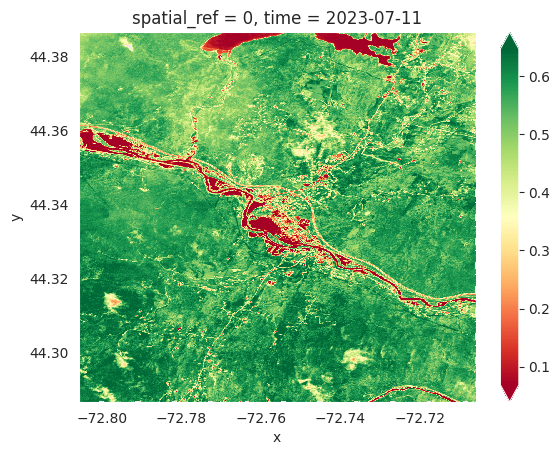

In [47]:
print(event_date)
ts_ds = ts_ds.sel(time=event_date,method='nearest').plot(robust=True,cmap='RdYlGn')

In [76]:
list_dates_datetime[0].date()
list_dates_datetime[0].strftime('%Y-%m-%d')
list_dates = [date_val.strftime('%Y-%m-%d') for date_val in list_dates_datetime]
date_selected_before,date_selected_after = find_target_dates(list_dates,event_date=event_date)

['2023-07-06', '2023-07-11', '2023-07-16']
./ndvi_masked_time_series.tif
['2023-07-06', '2023-07-11', '2023-07-16']
./ndwi_masked_time_series.tif


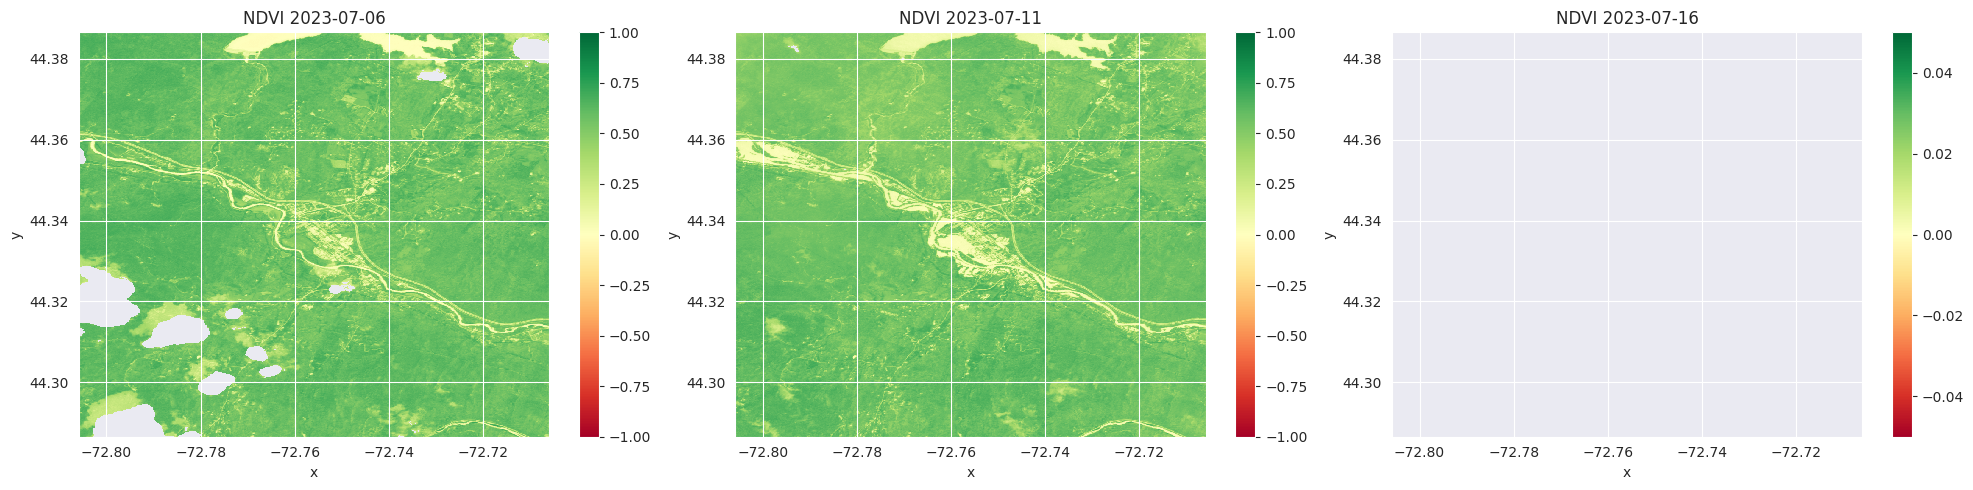

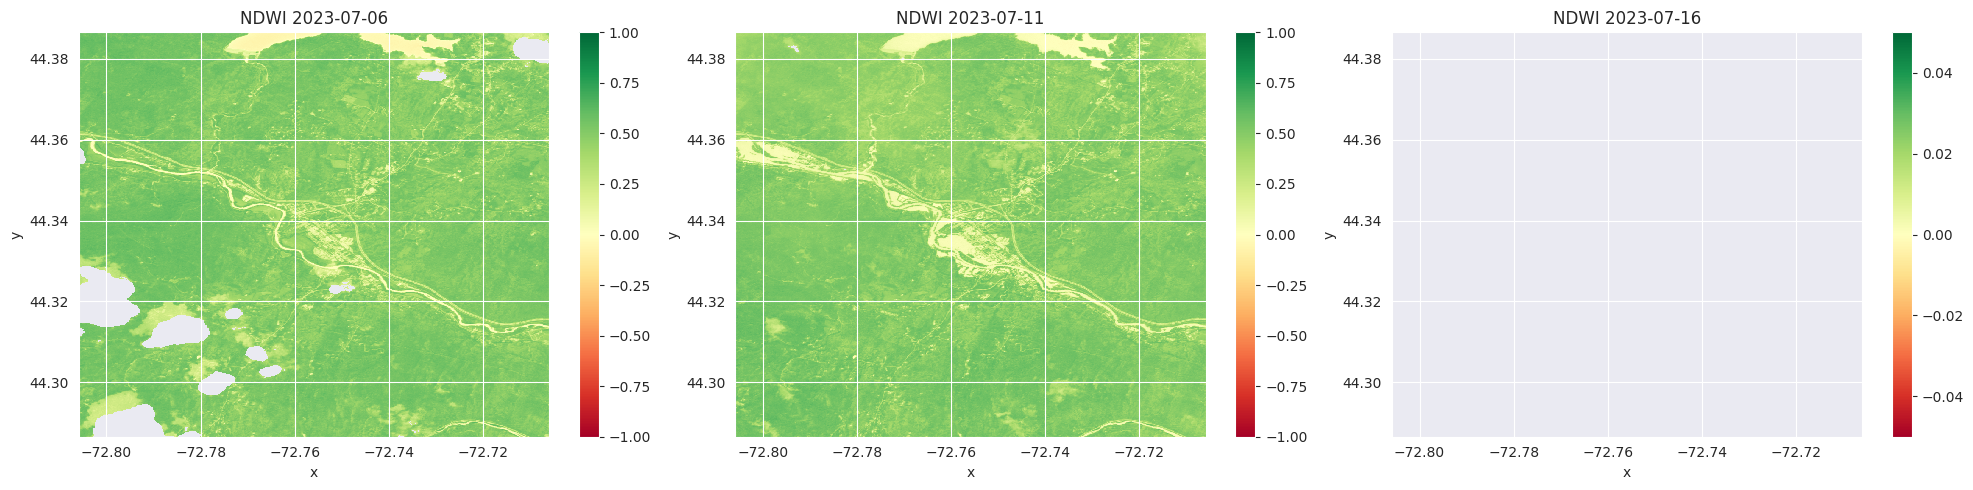

In [66]:
list_var_name = ['NDVI','NDWI']
list_outfile_name = [out_file_ndvi,out_file_ndwi]
for i, var_name in enumerate(list_var_name):
  var_filename = list_outfile_name[i]
  index_val = list_dates.index(date_selected_before)
  ts_ds = rxr.open_rasterio(var_filename,
                            masked=True,
                            cache=False) #masked for nodata and cache to avoid loading in memory
  print(list_dates[index_val:index_val+3])
  print(var_filename)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
  i=index_val
  for ax in axs:
    i=i +1
    ts_ds.sel(band=i).plot.imshow(clim=(-1,1),cmap='RdYlGn',ax=ax)
    title_str = f'{var_name} {list_dates[i-1]}'
    ax.set_title(title_str)
    #https://docs.xarray.dev/en/latest/user-guide/plotting.html#colormaps
    plt.tight_layout()
  del ts_ds

 We can see the following:
 - both NDVI and NDWI show the impact of flooding
 - the last image from the plot does not contain any information after masking.
 - flooding is more visible near the Winooski river as expected.


./ndvi_masked_time_series.tif
['2023-07-06', '2023-07-11', '2023-07-16']
169
170
171
./ndwi_masked_time_series.tif
['2023-07-06', '2023-07-11', '2023-07-16']
169
170
171


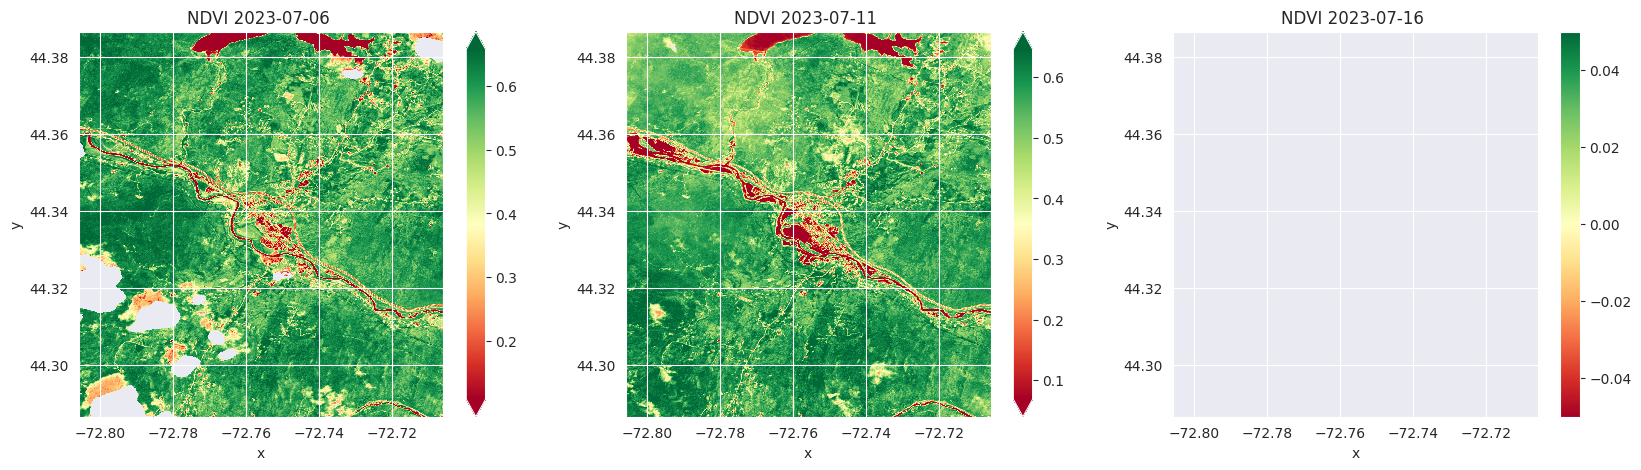

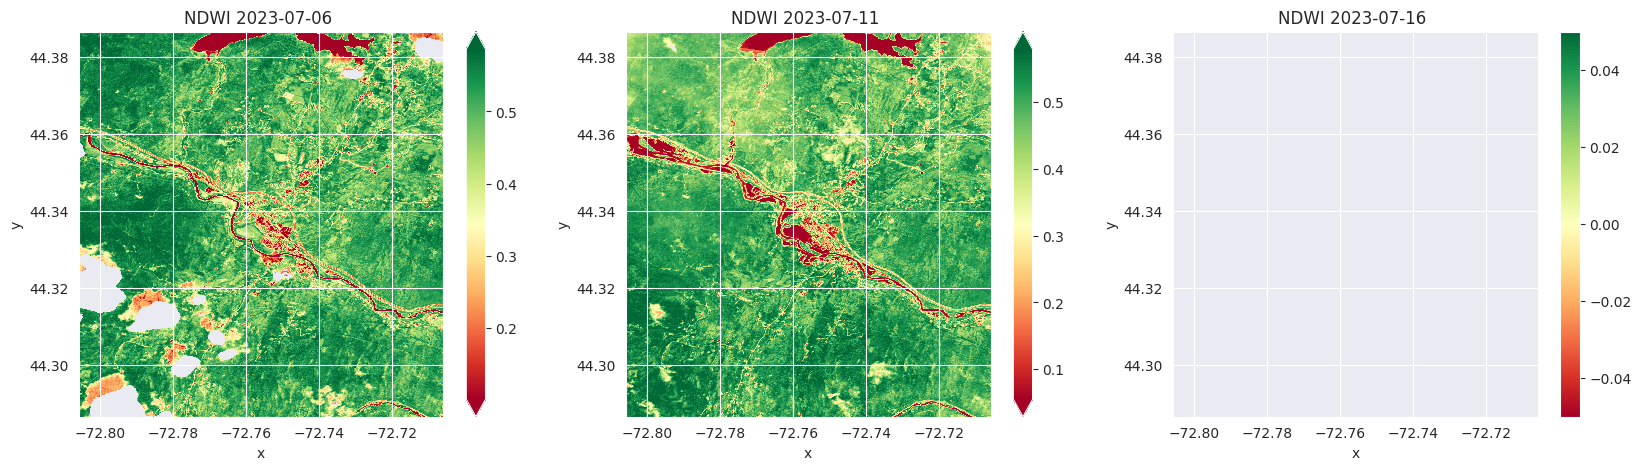

In [67]:
list_var_name = ['NDVI','NDWI']
list_outfile_name = [out_file_ndvi,out_file_ndwi]

for i, var_name in enumerate(list_var_name):
  var_filename = list_outfile_name[i]
  print(var_filename)
  index_val = list_dates.index(date_selected_before)
  ts_ds = rxr.open_rasterio(var_filename,
                            masked=True,
                            cache=False) #masked for nodata and cache to avoid loading in memory
  print(list_dates[index_val:index_val+3])
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
  i=index_val
  for ax in axs:
    i=i +1
    print(i)
    ts_ds.sel(band=i).plot.imshow(robust=True,cmap='RdYlGn',ax=ax)
    title_str = f'{var_name} {list_dates[i-1]} '
    ax.set_title(title_str)
    #https://docs.xarray.dev/en/latest/user-guide/plotting.html#colormaps

Using stretching date by date can improve the visualization at the expanse of reducing the across date comparison. The plot of before and after the event with stretching (2% quantile) shows similar results. Flooding is clearly visible in both NDVI and NDWI images.

##7.3 Finding majority land cover from SCL

We can use the SCL layer to find areas with high vegetation across the whole time series. It can also help us make sure that we track areas with vegetation.

To do so we compute the proportion of time a pixel is classified as vegetation across all time steps. To compute the proportion across the time series we created a function relying on block window reading that reclassifies and computes the proportion of a given category across individual pixels.

Useful links:

- https://gis.stackexchange.com/questions/163007/raster-reclassify-using-python-gdal-and-numpy
- https://gis.stackexchange.com/questions/163007/raster-reclassify-using-python-gdal-and-numpy/193100#193100


First, let's create a time series for all the SCL band images.

In [68]:
in_dir_files =  os.path.join(in_dir,'sentinel-2-l2a')
file_pattern = '*/*SCL.href_*.tif'
out_file_scl, out_file_scl_vrt, df_files_raster_scl =generate_time_series_raster(file_pattern=file_pattern,
                                                                                 in_dir=in_dir_files,
                                                                                 out_suffix='SCL',
                                                                                 out_dir=".")
print(out_file_scl)
ds_scl =rasterio.open(out_file_scl)
ds_scl.meta

./SCL_time_series.tif


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 1111,
 'height': 1111,
 'count': 186,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
        0.0, -8.999999999999984e-05, 44.38653872978746)}

### Reading raster blocks and processing

To create a new function to compute the proportion of times an image has been classified as vegetation, we make use of block reading. Reading an image using block (continuous chunk in images) allows for processing of very large images because at no point images are read fully in memory. Most, raster/image processing softwares use this strategy to process images.

Below we read the first block of the raster multiband (time series) for SCL using the rasterio generator. It is index as 0 with a 256x256 heightxwidth (rowsxcolumns) and a depth of 186. The depth dimension correspond to the band which are time series steps.

In [69]:
ds_block_windows = ds_scl.block_windows()
print(type(ds_block_windows))
index_window, window_val = next(ds_block_windows)
print(window_val)
print('index_window',index_window)
array_val = ds_scl.read(window=window_val, masked=True)
print(array_val.dtype)
print(array_val.shape)
array_val

<class '_cython_3_0_11.generator'>
Window(col_off=0, row_off=0, width=256, height=256)
index_window (0, 0)
uint8
(186, 256, 256)


masked_array(
  data=[[[--, --, --, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         ...,
         [--, 9, 9, ..., 9, 9, 9],
         [--, 9, 9, ..., 9, 9, 9],
         [--, 9, 9, ..., 9, 9, 9]],

        [[--, --, --, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         ...,
         [--, 9, 9, ..., 8, 8, 8],
         [--, 9, 9, ..., 8, 8, 8],
         [--, 9, 9, ..., 8, 8, 8]],

        [[--, --, --, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         [9, 9, 9, ..., 9, 9, 9],
         ...,
         [--, 9, 9, ..., 9, 9, 9],
         [--, 9, 9, ..., 9, 9, 9],
         [--, 9, 9, ..., 9, 9, 9]],

        ...,

        [[--, --, --, ..., 8, 8, 8],
         [8, 8, 8, ..., 8, 8, 8],
         [8, 8, 8, ..., 8, 8, 8],
         ...,
         [--, 8, 8, ..., 8, 8, 8],
         [--, 8, 8, ..., 8, 8, 8],
         [--, 8, 8, ..., 8, 8, 8]],

        [[--, --, --, ..., 4, 4, 4],
         [4, 4, 4, ..., 4, 4, 4

Let's illustrate how we built the function to compute the proportion of pixel with vegetation (class labeled as 4 in SCL). There are two steps:
- reclassify pixel profiles in array with specific value (4) into a boolean array with 1 and zero
- compute the mean of the boolean array, taking into account the NAs.

In [70]:
a_test = array_val.copy()
a_test = np.where(a_test==4,1,0)
a_prop = np.nanmean(a_test,axis=(0),keepdims=True)
a_prop

array([[[0.        , 0.        , 0.        , ..., 0.12903226,
         0.12903226, 0.12903226],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.12903226,
         0.12903226, 0.12903226],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.12365591,
         0.12365591, 0.12365591],
        ...,
        [0.        , 0.12365591, 0.12365591, ..., 0.23655914,
         0.23655914, 0.25806452],
        [0.        , 0.12365591, 0.12365591, ..., 0.2311828 ,
         0.2311828 , 0.24731183],
        [0.        , 0.1344086 , 0.1344086 , ..., 0.2311828 ,
         0.2311828 , 0.24731183]]])

### Compute raster class proportion and create function

We can wrap these steps into a function call 'proportion_pix'. Note that it takes as input:
- a numpy array
- a category value to be reclassified to compute the proportion

The output array is 1x256x256 while the initial input was 186x256x256. We reduced the band dimension from 186 to 1 and changes the data type from uint8 to float.

In [71]:
array_out  = proportion_pix(array_val,
                            val=4)
print(array_out.shape)
print(array_out.dtype)
array_out

(1, 256, 256)
float64


array([[[0.        , 0.        , 0.        , ..., 0.12903226,
         0.12903226, 0.12903226],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.12903226,
         0.12903226, 0.12903226],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.12365591,
         0.12365591, 0.12365591],
        ...,
        [0.        , 0.12365591, 0.12365591, ..., 0.23655914,
         0.23655914, 0.25806452],
        [0.        , 0.12365591, 0.12365591, ..., 0.2311828 ,
         0.2311828 , 0.24731183],
        [0.        , 0.1344086 , 0.1344086 , ..., 0.2311828 ,
         0.2311828 , 0.24731183]]])

Now, we can create a function to apply the proportion_pix function to every block of the raster image. We called this function called 'raster_compute_proportion' which take the following input parameters:

- rast_in: input file
- dtype_val: output data type 'Float32' if None
- out_filename: name of the output file name e.g. 'prop_test.tif'
- out_dir: output directory if None then '.'
- count_val: number of output band if None, it will be set to 1
- val: class value to reclassify into proportion.

In [72]:
out_filename_prop = raster_compute_proportion(
                          rast_in=out_file_scl,
                          dtype_val = None,
                          out_filename='prop_test.tif',
                          out_dir=None,
                          count_val = None,
                          val=4)
out_filename_prop

File already exists, removing file


'prop_test.tif'

Let's  take a look at the output. We have a one-band file with min prop of 0 and max proportion of about 30%. This means for the max pixel that for 30% of dates we have vegetation.

In [73]:
dst_prop = rasterio.open(out_filename_prop)
print(dst_prop.meta)
r_prop = dst_prop.read()
print(r_prop.shape)
print(r_prop.min())
print(r_prop.max())
r_prop

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 1111, 'height': 1111, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
       0.0, -8.999999999999984e-05, 44.38653872978746)}
(1, 1111, 1111)
0.0
0.2956989247311828


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.22043011,
         0.22043011, 0.17204301],
        [0.12365591, 0.12365591, 0.1344086 , ..., 0.22043011,
         0.17204301, 0.17204301],
        ...,
        [0.13978495, 0.13978495, 0.14516129, ..., 0.1827957 ,
         0.1827957 , 0.1827957 ],
        [0.14516129, 0.14516129, 0.14516129, ..., 0.16666667,
         0.16666667, 0.16666667],
        [0.14516129, 0.14516129, 0.14516129, ..., 0.16666667,
         0.16666667, 0.16666667]]])

Let's plot the data use rioxarray. We note that during winter, vegetation can be covered by snow. This is particularly true for grass/lawn in contrast to tree covered areas. Using the proportion image and the true color composite plot we can define areas in the middle of the raster images that match the flooded areas.

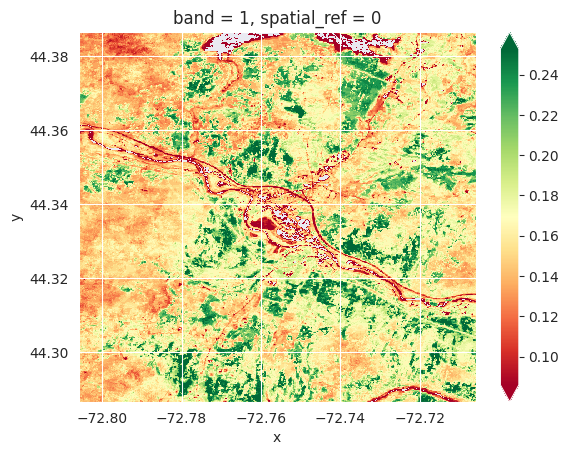

In [91]:
ds_var = rxr.open_rasterio(out_filename_prop,
                          masked=True,
                          cache=False) #masked for nodata and cache to avoid loading in memory
ds_var.sel(band=1).plot.imshow(robust=True,cmap='RdYlGn') #with image enhancement using 2% percentifle for strchening

Now let's define the polygons that we can use to extract pixel values.

In [86]:

if convert_to_dms is True:
  x_val = dms_to_dd(centroid_val[1])
  y_val = dms_to_dd(centroid_val[0])
else:
  x_val = centroid_val[1]
  y_val = centroid_val[0]
bbox_poly_gdf = polygon_from_centroid(x_val,y_val,size=0.1)

bbox_focus_area1_gdf = polygon_from_centroid(x_val,y_val,size=0.02)
bbox_focus_area2_gdf = polygon_from_centroid(x_val+0.02,y_val+0.02,size=0.02)

m = bbox_poly_gdf.explore(color="red", name="AOI",style_kwds=dict(fill=False, width=2))
m = bbox_focus_area1_gdf.explore(m=m, color="blue",name='Focus area 1',style_kwds=dict(fill=False, width=2))
m = bbox_focus_area2_gdf.explore(m=m, color="green",name='Focus area 2',style_kwds=dict(fill=False, width=2))

# this is completely optional
folium.LayerControl().add_to(m)
m

#Note that you need to provide a colormap of the form lambda x: (R,G,B,A) where R,G,B,A are floats between 0 and 1.

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

##7.4 Time series profile

We detected the impact of flooding visiually in RGB true color composite and NDVI and NDVWI plot images.
We now examine time series data to see if we can detect changes in the time profiles when flooding occured. We experiment with three ways of carrying the detection using time profiles:

- extract pixel time series: select a specific pixel and plot its temporal profile.

- extract average time series from a block raster: average a block/chunk from the raster image to create a unique temporal profile from multiple pixel.

- extract average time series from polygon of impact area: select a specific area delimited by a polygon and average the time profile for all the pixels in the polygon.

###Extract Individual pixel time series profile

We extract the time series profile for a pixel in two ways: using the pixel value and or the spatial coordinates.

Useful links:

- https://gis.stackexchange.com/questions/358036/extracting-data-from-a-raster/358058#358058


(-72.79238972127818, 44.37303872978746)
186
(186,)


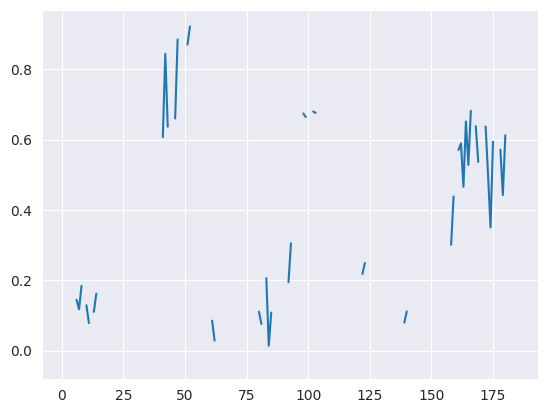

In [77]:
#extract one pixel e.g.

height_val = 150 #row 150
width_val = 150  #column 150
coords_tuple =ds_ndvi.transform * (height_val,width_val)
print(coords_tuple)
print(ds_ndvi.count)
list_bands = list(np.arange(1,ds_ndvi.count+1)) #we want to extract one value per band
## we need a list of tuple
list_vals = [val for val in ds_ndvi.sample([coords_tuple],indexes=list_bands)]
print(list_vals[0].shape)
pix_val = list_vals[0]
plt.plot(pix_val)

###Block of pixels time series averaged

Let's read a specific raster block and examine the average time series profile. After creating a generator, we can read block by block as shown below.

In [78]:
ds_block_windows = ds_ndvi.block_windows()
type(ds_block_windows)
index_window, window_val = next(ds_block_windows)
print(window_val)
print(window_val.flatten())
array_val = ds_ndvi.read(window=window_val, masked=True)
print(array_val.dtype)
array_val.shape

Window(col_off=0, row_off=0, width=256, height=256)
(0, 0, 256, 256)
float32


(186, 256, 256)

Let's plot the location of the first window we used. We are interested in selecting a specific raster block. To do so we plot all the block location information on size and location.

We create a new function to generate polygons matching the blocks/chunks of the raster image and help in the visualization. The function takes in a dataset object of the rasterio package.

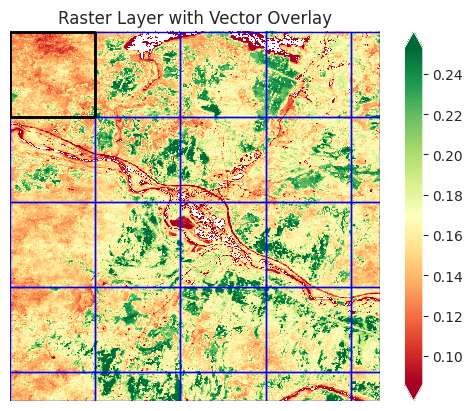

In [92]:
gdf_window_coords = convert_window_block_to_poly(ds=ds_ndvi)

f, ax = plt.subplots()

ds_var.sel(band=1).plot.imshow(robust=True,
                               cmap='RdYlGn',
                               ax=ax) #with image enhancement using 2% percentifle for strchening

gdf_window_coords.plot(color='None',
                       edgecolor='blue',
                       linewidth=1,
                       ax=ax)

(gdf_window_coords.iloc[:1,:]
                 .plot(color='None',
                    edgecolor='black',
                    linewidth=2,
                    ax=ax,
                    zorder=4))

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()

In [ ]:
gdf_window_coords.loc[1,:]

Window(col_off=0, row_off=0, width=256, height=256)
float32
(186, 256, 256)
(186,)
<class 'numpy.ma.core.MaskedArray'>
float32


<ipython-input-93-fd2c66e07550>:6: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(array_val,axis=(1,2))


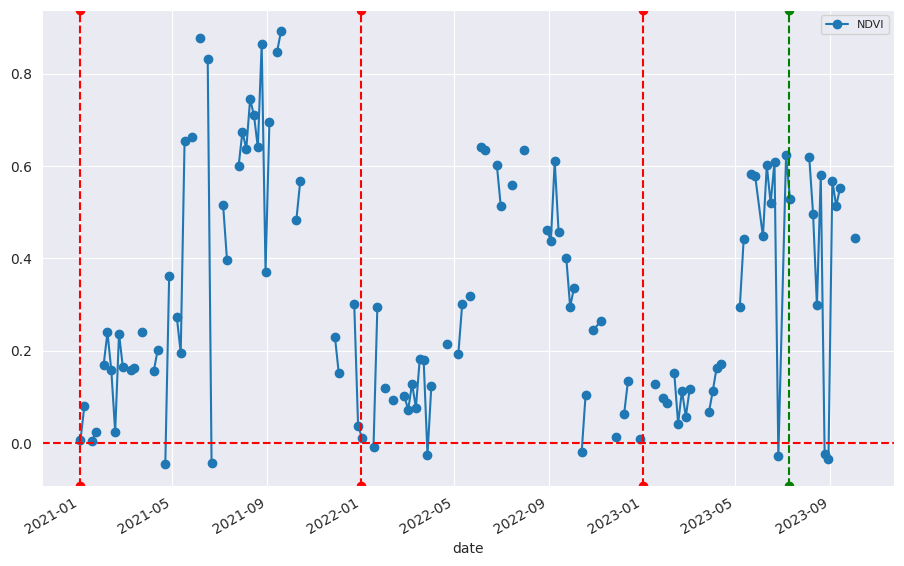

In [93]:
array_val = ds_ndvi.read(window=window_val, masked=True)
print(window_val)
print(array_val.dtype)
print(array_val.shape)
#Now get the first pixel
mean_val = np.nanmean(array_val,axis=(1,2))
print(mean_val.shape)
print(type(mean_val))
print(mean_val.dtype)
df_window = pd.DataFrame.from_dict({'mean': mean_val,
                                   'date': list_dates})

df_window['date'] = pd.to_datetime(df_window['date'])
df_window.set_index('date',inplace=True)


f, ax = plt.subplots(figsize=(11, 7))
df_window.plot(y='mean',ax=ax,marker='o')
ax.legend(labels=['NDVI'],prop={'size':8})
ax.axhline(0, color="red",linestyle="--")
style="-o"
ax.axvline("2021-01-01",color="red",marker='o',linestyle="--")
ax.axvline("2022-01-01",color="red",marker='o',linestyle="--")
ax.axvline("2023-01-01", color="red",marker='o',linestyle="--")
ax.axvline(event_date, color="green",marker='o',linestyle="--")

<ipython-input-94-071e3f236f6e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_window_agg_M = df_window.resample('M').mean()


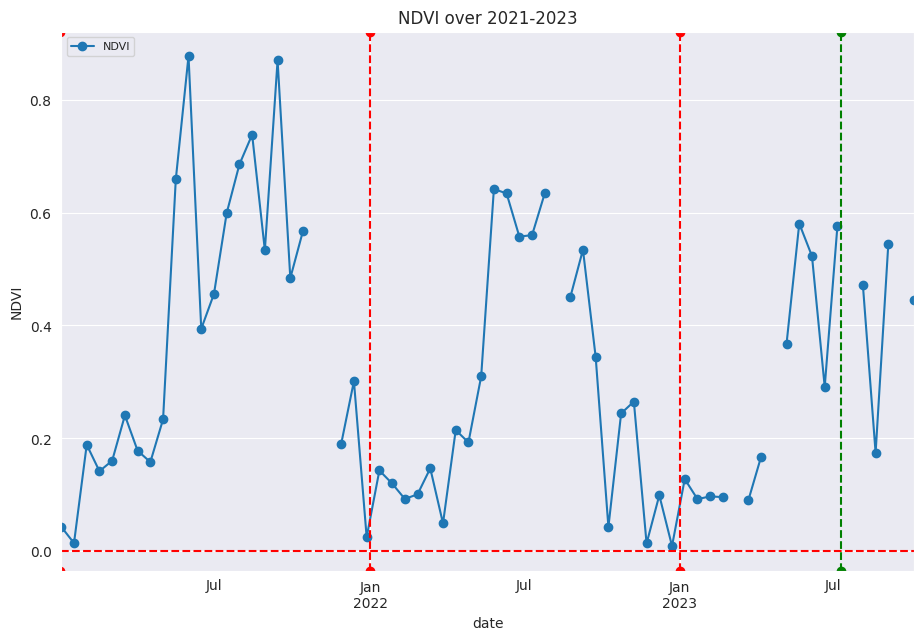

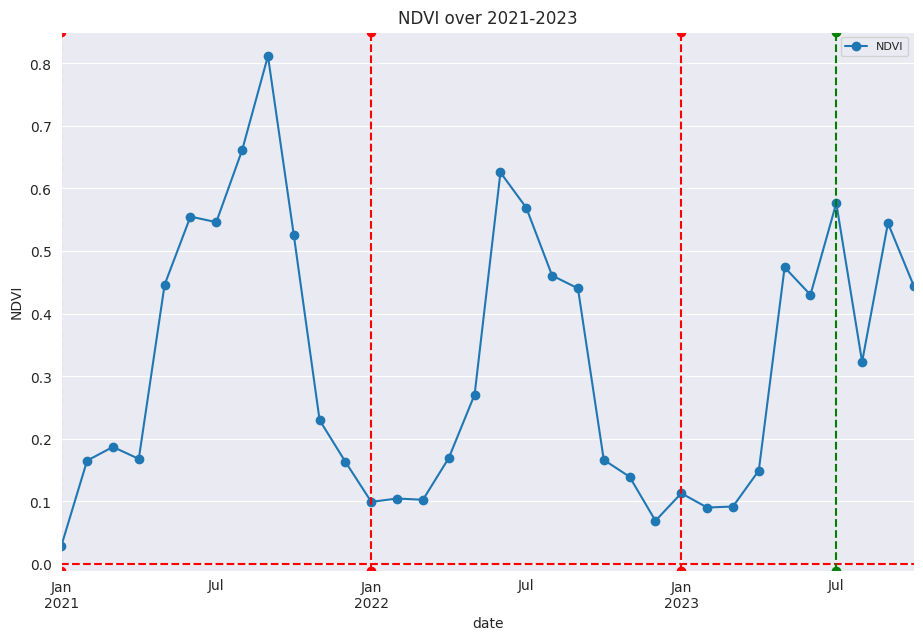

In [94]:
df_window_agg_15D = df_window.resample('15D').mean()
df_window_agg_M = df_window.resample('M').mean()

list_df_window = [df_window_agg_15D,df_window_agg_M]

for df in list_df_window:
  plot_time_series(df=df,
                 col_name = 'mean',
                 event_date = event_date,
                 date_col=None,
                 label_y='NDVI',
                 title=None,
                 out_filename=None,
                 out_dir=None,
                 save_fig=None)

### Extract pixel values using geodataframe

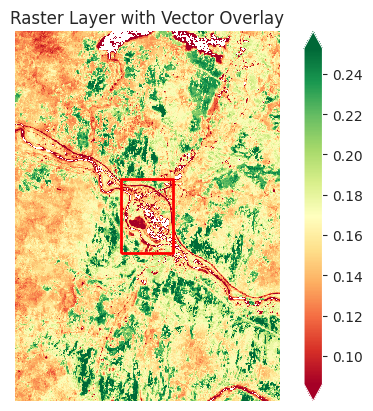

In [95]:
# function to return polygon

bbox_poly_ndvi_gdf = bbox_focus_area1_gdf.copy()

f, ax = plt.subplots()

ds_var.sel(band=1).plot.imshow(robust=True,
                               cmap='RdYlGn',
                               ax=ax) #with image enhancement using 2% percentifle for strchening
bbox_poly_ndvi_gdf.plot(color='None',
                    edgecolor='red',
                    linewidth=2,
                    ax=ax,
                    zorder=4)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()

In [96]:
#https://rasterio.readthedocs.io/en/stable/api/rasterio.windows.html#rasterio.windows.from_bounds
#https://github.com/patrickcgray/open-geo-tutorial
total_bounds = bbox_poly_ndvi_gdf.total_bounds
print(total_bounds)
print(total_bounds.shape)
print(type(total_bounds))

from rasterio.windows import from_bounds
ds_ndvi = rasterio.open(out_file_ndvi)
array_w = ds_ndvi.read(window=from_bounds(
                               left=total_bounds[0], #Left (west) bounding coordinates, minx
                               bottom=total_bounds[1], #Bottom (south) bounding coordinates, miny
                               right=total_bounds[2], #Right (east) bounding coordinates,maxx
                               top=total_bounds[3], #Top (north) bounding coordinates,maxy
                               transform=ds_ndvi.transform))
array_w.shape

[-72.76588889  44.32652778 -72.74588889  44.34652778]
(4,)
<class 'numpy.ndarray'>


(186, 222, 222)

<ipython-input-97-2d24d5478fc2>:21: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(array_w,axis=(1,2))
<ipython-input-97-2d24d5478fc2>:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_window_agg_M = df_window.resample('M').mean()


(186,)
<class 'numpy.ndarray'>
float32
2023-07-10


<ipython-input-97-2d24d5478fc2>:21: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(array_w,axis=(1,2))
<ipython-input-97-2d24d5478fc2>:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_window_agg_M = df_window.resample('M').mean()


(186,)
<class 'numpy.ndarray'>
float32
2023-07-10


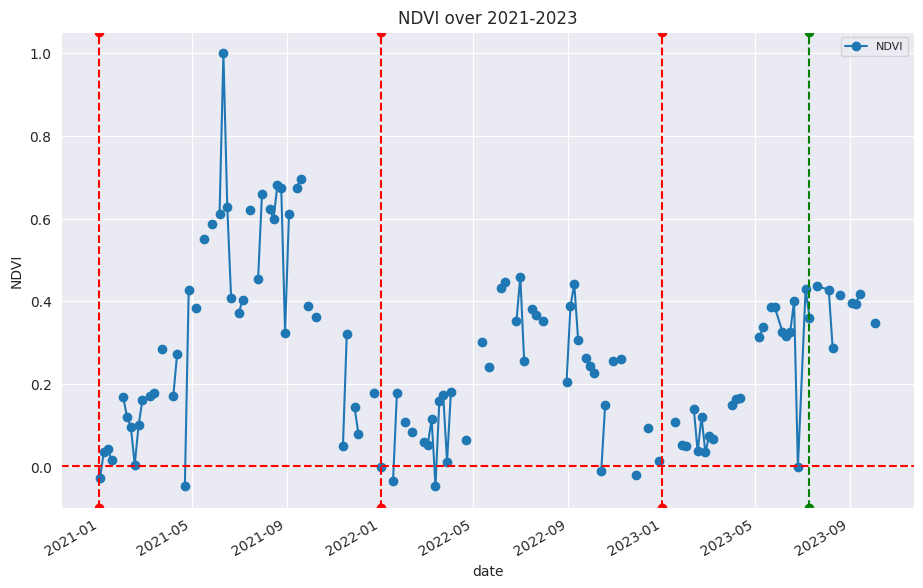

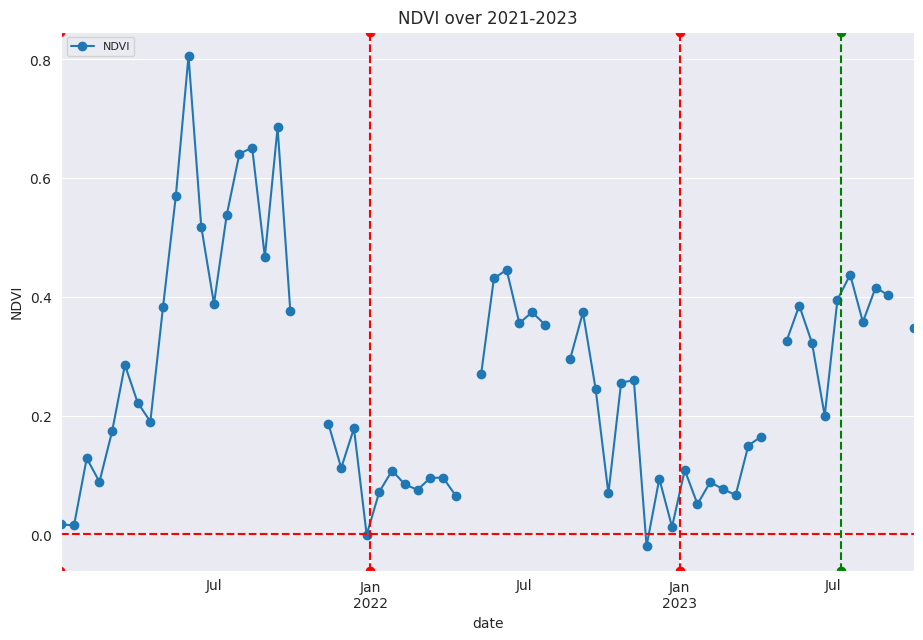

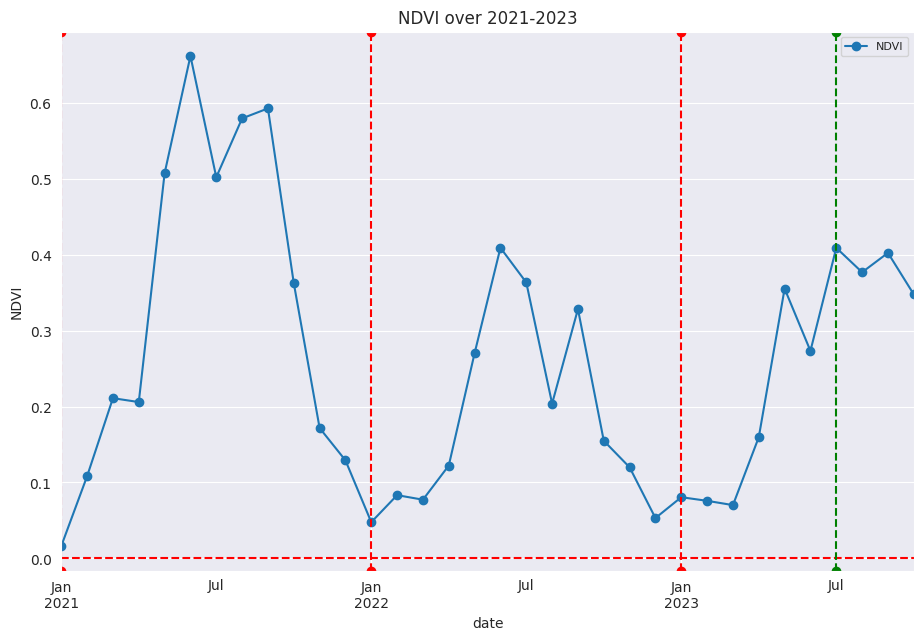

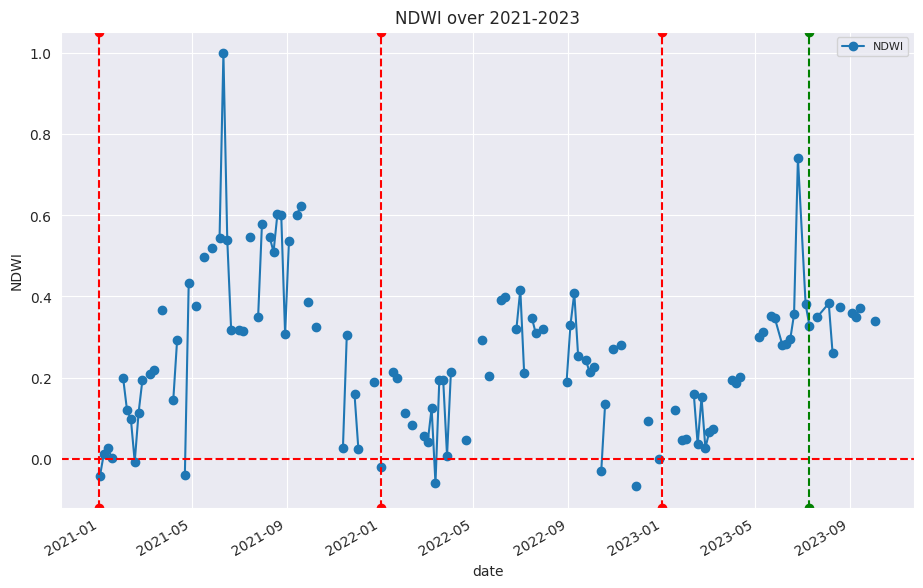

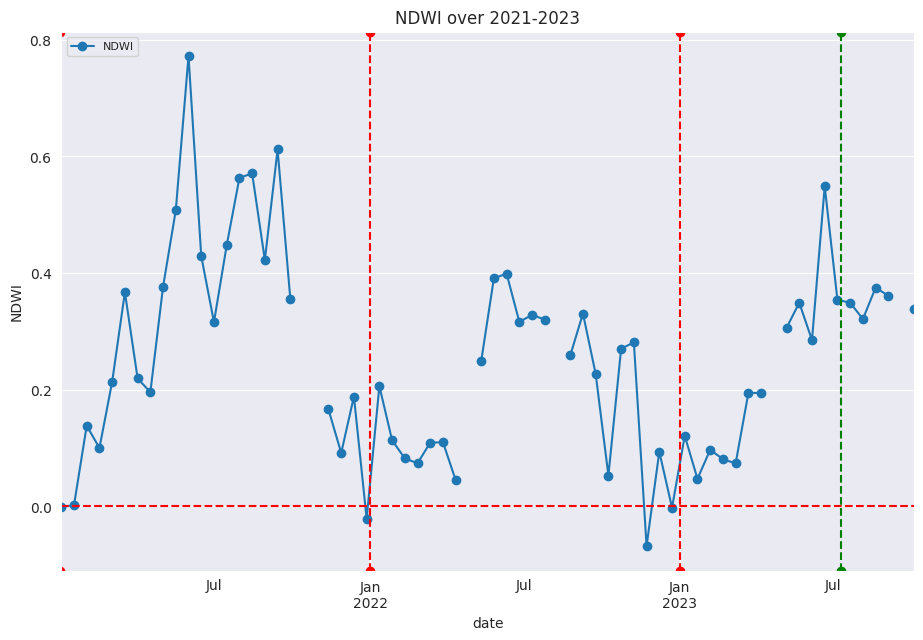

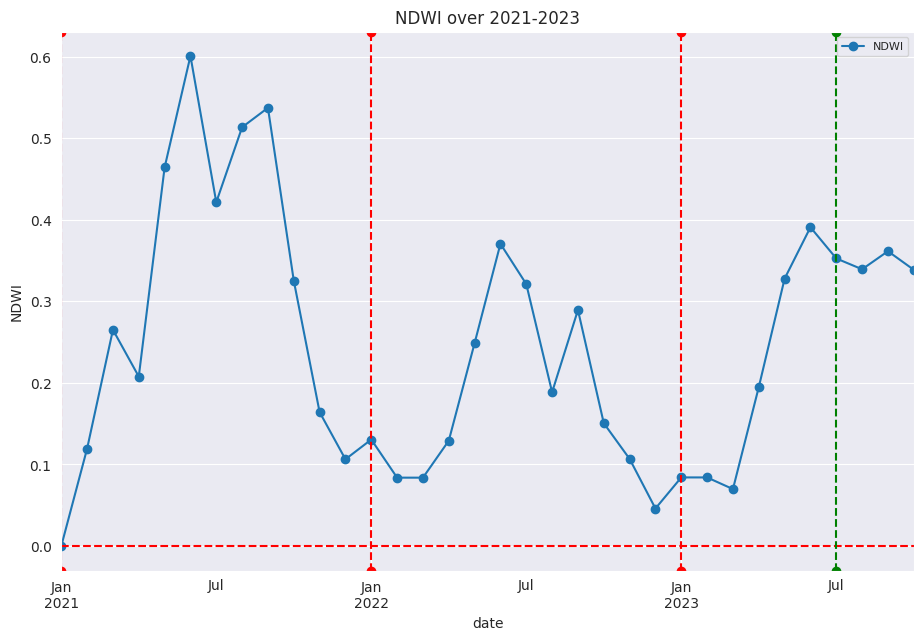

In [97]:
list_var_name = ['NDVI','NDWI']
list_outfile_name = [out_file_ndvi,out_file_ndwi]


for index,out_file in enumerate(list_outfile_name):

  var_name = list_var_name[index]

  #https://rasterio.readthedocs.io/en/stable/api/rasterio.windows.html#rasterio.windows.from_bounds
  #https://github.com/patrickcgray/open-geo-tutorial
  from rasterio.windows import from_bounds
  ds_var = rasterio.open(out_file)
  array_w = ds_var.read(window=from_bounds(
                                left=total_bounds[0], #Left (west) bounding coordinates, minx
                                bottom=total_bounds[1], #Bottom (south) bounding coordinates, miny
                                right=total_bounds[2], #Right (east) bounding coordinates,maxx
                                top=total_bounds[3], #Top (north) bounding coordinates,maxy
                                transform=ds_ndvi.transform))
  array_w.shape

  mean_val = np.nanmean(array_w,axis=(1,2))
  print(mean_val.shape)
  print(type(mean_val))
  print(mean_val.dtype)
  print(event_date)

  df_window = pd.DataFrame.from_dict({'mean': mean_val,
                                   'date': list_dates})

  df_window['date'] = pd.to_datetime(df_window['date'])
  df_window.set_index('date',inplace=True)

  df_window_agg_15D = df_window.resample('15D').mean()
  df_window_agg_M = df_window.resample('M').mean()

  list_df_window = [df_window,df_window_agg_15D,df_window_agg_M]

  for df_val in list_df_window:
    plot_time_series(df=df_val,
                 col_name = 'mean',
                 event_date = event_date,
                 date_col=None,
                 label_y=var_name,
                 title=None,
                 out_filename=None,
                 out_dir=None,
                 save_fig=None)



#Chunk and parallel processing with window rasterio

- https://medium.com/@lynzt/python-pass-a-function-to-another-function-and-run-it-with-args-b24141312bd7
- https://gis.stackexchange.com/questions/163007/raster-reclassify-using-python-gdal-and-numpy
- https://numpy.org/doc/stable/reference/generated/numpy.apply_over_axes.html#numpy.apply_over_axes
- https://medium.com/@bernhard_sassik/scalable-multi-processing-with-rasterio-c3544a404286
- https://rasterio.groups.io/g/main/topic/best_way_of_doing_concurrent/28593754?p=
- https://www.google.com/search?channel=fen&client=firefox-b-1-d&q=rasterio+window+with+multi+processing
- https://pygis.io/docs/e_new_rasters.html
- https://www.uv.es/gonmagar/blog/2018/11/11/RasterioExample
- https://medium.com/@danielmoyo/raster-data-in-python-part-ii-working-with-geographic-coordinates-a368708de5f2

- https://stackoverflow.com/questions/54501232/iteratively-load-image-block-by-block-where-blocks-are-partially-overlapped

- https://colab.research.google.com/github/bwsi-hadr/03-Intro-to-GIS/blob/master/03_Intro_to_GIS.ipynb

#Folium and raster

- https://discuss.streamlit.io/t/showing-geotiff-raster-data/11170/2




#8.Conclusions

In this blog/exercise, we explored the impact of a major flooding event in Vermont using Sentinel 2, satellite imagery data. We showed how to download and process Sentinel 2 data for multiple dates (almost three years) using COGS and STAC framework.

The overall gaol was also to show how to leverage Sentinel 2 data once procesed. We used Sentinel2 data to assess the impact of flooding in multiple ways:

1. Visual impact with raw bands:

We compared the date before and after visually using raw bands from Sentinel 2.

- visual impact of flooding using true color composite (RGB)
- visual impact using NIR (band 08).

2. Visual impact with NDVI and NDWI indices

Raw spectral bands are useful but spectral indices made up of a combination of bands can help in highlitghting specific features on the ground surface.
We created the Normalized Difference Vegetation Index and the Normalized Difference Water Index to detect the impact of flooding on vegetation and water areas. We exepect NDVI values close to zero or negative for flooded areas and for NDWI values we expect hight values (above 0.5) for flooded areas.

3. Using time series profiles

We examined individual and average time sereis profile at dfferent location int the AOI and detected drop or rise at the time of the event for NDVI and NDWI respectively.


**Improvements**

We hope that this blog/exercise provided a complete example of workflow for the use of Sentinel 2 data with STAC and COGS. As expected, there are several improvements that could be made:

- thresholds results using NDVI or NDWI to map flooding event.
- use an algorithm/model map the area flooded.

#8.References


Obregón, M.A., Rodrigues, G., Costa, M.J., et al. (2019). Validation of ESA Sentinel-2 L2A aerosol optical thickness and columnar water vapour during 2017-2018. Remote Sensing, 11(14), 1649. https://doi.org/10.3390/rs11141649

Schläpfer, D., Borel, C.C., Keller, J., et al. (1998). Atmospheric precorrected differential absorption technique to retrieve columnar water vapor. Remote Sensing of Environment, 65(3), 353-366. https://doi.org/10.1016/S0034-4257(98)00044-3.

Gascon F., Bouzinac C., Thépaut O., et al. (2017). Copernicus Sentinel-2A calibration and products validation status. Remote Sensing, 9(6), 584. https://doi.org/10.3390/rs9060584


In [ ]:
############################# END OF SCRIPT ###################################